In [1]:
'''This is an implementation of the RTS smoother algorithm as described in 
https://jwmi.github.io/ASM/6-KalmanFilter.pdf 

The system dynamics are replaced by a linear approximation via the jacobian. 
'''

'This is an implementation of the RTS smoother algorithm as described in \nhttps://jwmi.github.io/ASM/6-KalmanFilter.pdf \n\nThe system dynamics are replaced by a linear approximation via the jacobian. \n'

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
from jax import jacrev
import jax.numpy as jnp
from scipy.integrate import solve_ivp

In [3]:
params = np.array([0.3,0.1])

def det_model(y,args):
    S,I,R = y
    N = S + I + R
    beta,gamma = args 

    dS = -(beta * S * I)/N
    dI = (beta * S * I)/N - gamma * I
    dR = gamma * I

    return jnp.array([dS,dI,dR])

SIR_JAC = jacrev(lambda y: det_model(y,params),argnums = (0,))
F = lambda y: SIR_JAC(y)[0]

In [4]:
'''Tau leaping model so we have some stochasticity. '''

days = 100
delta_t = 1.0
rng = np.random.default_rng(0)

def model(theta,rng,*,days,delta_t,log = False): 
    beta,gamma = theta
    if log: 
        beta = np.exp(beta)
        gamma = np.exp(gamma)

    S = np.zeros(days * int(1/delta_t))
    I = np.zeros(days * int(1/delta_t))
    R = np.zeros(days * int(1/delta_t))

    #Initial condition
    S[0] = 100
    I[0] = 1
    R[0] = 0

    N = S[0] + I[0] + R[0]

    for t in range(1,int(1/delta_t) * days): 

        #Rate equations
        dN_SI = rng.poisson(max(beta * (S[t-1] * I[t-1]/N) * delta_t,0))
        dN_SI = min(dN_SI,S[t-1])

        dN_IR = rng.poisson(max(I[t-1] * gamma * delta_t,0))
        dN_IR = min(dN_IR,I[t-1])

        S[t] = S[t-1] - dN_SI
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR

    return (S,I,R) 

theta = (0.3,0.1) #Real parameters
S_full,data_full,R_full = model(theta,rng,days = days,delta_t = delta_t)


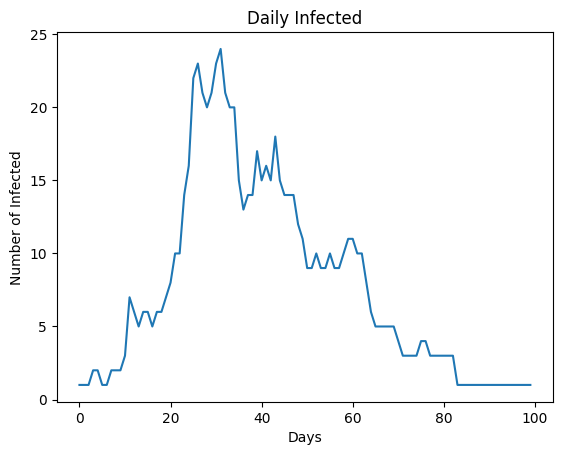

In [5]:
#Extract the data daily
data_real = data_full[::int(1/delta_t)]

plt.title('Daily Infected')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_real)

In [6]:
'''First pass is the Kalman Filter.'''

m_0 = np.array([100.,1.,0.])
V_0 = np.eye(3)

process_noise = 100
Q = process_noise * np.eye(3)
H = np.array([[0.,1.,0.]])

measurement_noise = 1000
R_obs = measurement_noise * np.eye(1)

total_steps = days * int(1/delta_t)

m_prior = np.zeros((total_steps,3))
m_post = np.zeros((total_steps,3))
cov_post = np.zeros((total_steps,3,3))
cov_prior = np.zeros((total_steps,3,3))

cov_prior[0,...] = V_0
m_prior[0,...] = m_0

for obs_index in range(0,len(data_full)): 
    if(obs_index > 0): 
        m_prior[obs_index,...] = m_post[obs_index-1,:] + det_model(m_post[obs_index - 1,:],params) * delta_t
        cov_prior[obs_index,...] = F(m_post[obs_index-1,...]) @ cov_post[obs_index-1,...] @ F(m_post[obs_index-1,...]).T + Q

    K = cov_prior[obs_index,...] @ H.T @ np.linalg.pinv(H @ cov_prior[obs_index,...] @ H.T + R_obs)
    m_post[obs_index,...] = np.clip(m_prior[obs_index,...] + K @ (data_full[obs_index] - H @ m_prior[obs_index,...]),a_min = 0., a_max = None)
    cov_post[obs_index,...]  = cov_prior[obs_index,...] - K @ H @ cov_prior[obs_index,...] 


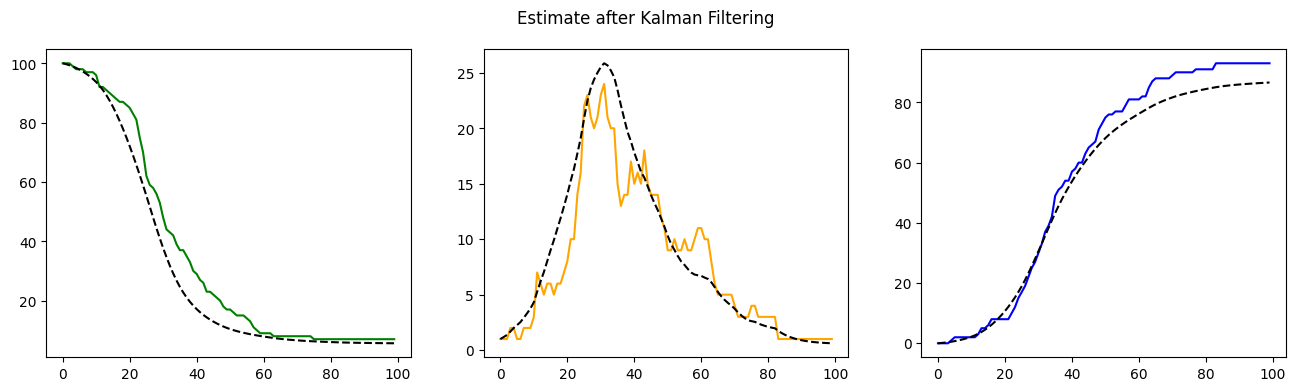

In [7]:
fig,ax = plt.subplots(ncols = 3,nrows = 1,figsize = (16,4),sharex = True)
plt.suptitle('Estimate after Kalman Filtering')

ax[0].plot(np.arange(0,days,delta_t),S_full,color = 'green')
ax[1].plot(np.arange(0,days,delta_t),data_full,color = 'orange')
ax[2].plot(np.arange(0,days,delta_t),R_full,color = 'blue')

for i in range(3): 
    ax[i].plot(np.arange(0,days,delta_t),m_post[:,i],'--',color = 'black')

In [8]:
'''RTS Smoother'''

'''Need m_post, cov_post, and cov_prior'''

RTS_m_post = np.zeros((total_steps,3))
RTS_cov_post = np.zeros((total_steps,3,3))

RTS_m_post[-1,:] = m_post[-1,...]
RTS_cov_post[-1,:] = cov_post[-1,...]

for obs_index in range(len(data_full)-2,-1,-1): 
    C_i = cov_post[obs_index,...] @ F(m_post[obs_index+1,...]).T @ np.linalg.pinv(cov_prior[obs_index+1,...])
    RTS_m_post[obs_index,...] = np.clip(m_post[obs_index,...] + C_i @ (RTS_m_post[obs_index + 1,...] - m_prior[obs_index + 1,...]),a_min = 0., a_max = None)
    RTS_cov_post[obs_index,:] = cov_post[obs_index,...] + C_i @ (RTS_cov_post[obs_index + 1,:] - cov_prior[obs_index + 1,...]) @ C_i.T


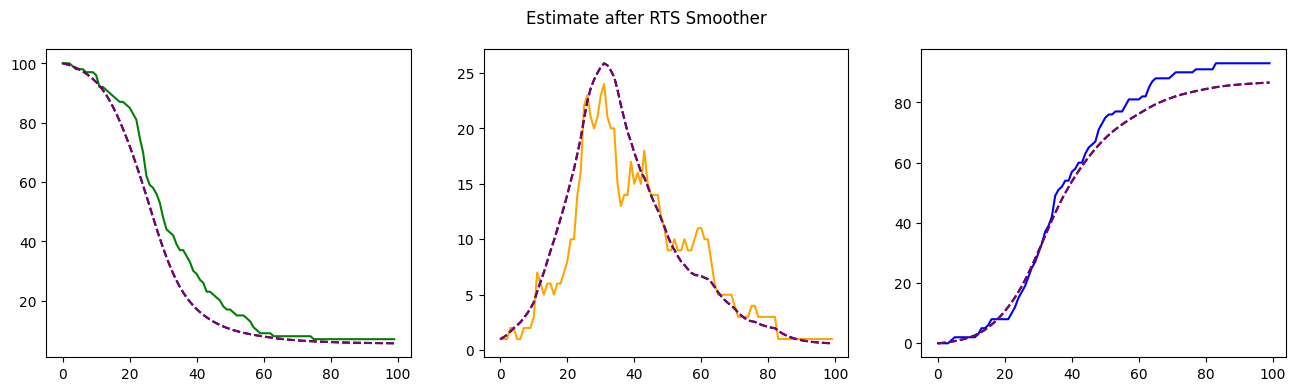

In [9]:
fig,ax = plt.subplots(ncols = 3,nrows = 1,figsize = (16,4),sharex = True)
plt.suptitle('Estimate after RTS Smoother')

ax[0].plot(np.arange(0,days,delta_t),S_full,color = 'green')
ax[1].plot(np.arange(0,days,delta_t),data_full,color = 'orange')
ax[2].plot(np.arange(0,days,delta_t),R_full,color = 'blue')

for i in range(3): 
    ax[i].plot(np.arange(0,days,delta_t),RTS_m_post[:,i],'--',color = 'black')
    ax[i].plot(np.arange(0,days,delta_t),m_post[:,i],'--',color = 'purple')